# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Voting Classifiers
- A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. 
- This majority-vote classifier is called a **hard voting classifier**.

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

In [4]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the **highest class probability**, averaged over all the individual classifiers. 
- This is called **soft voting**.

In [6]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

voting_clf = VotingClassifier(
    [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting="soft"
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [7]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred_proba))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


- Side note: in the code chunk above, clf is defined in (...), which is a **tuple**, but the code will also work if we use [...] instead, which is a **list**.
- The biggest difference between tuples and lists are that **lists are mutable** whereas **tuples are immutable**.

# Bagging and Pasting
- One way to get a diverse set of classifiers is to use very **different training algorithms**, as just discussed.
- Another approach is to use the **same training algorithm** for every predictor, but to train them on **different random subsets** of the training set. 
    - When sampling is performed **with replacement**, this method is called **Bagging** (short for **bootstrap aggregating**). 
    - When sampling is performed **without replacement**, it is called **Pasting**.
- Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. 
    - The aggregation function is typically the **statistical mode** (like a hard voting classifier) for classification, or the **average** for regression.
- Scikit-Learn offers a simple API for both bagging and pasting with the **BaggingClassifier** class (or **BaggingRegressor** for regression).
    - If we want to use **Pasting**, we set `bootstrap=False`.

In [8]:
# Now we ensemble 500 DecisionTreeClassifiers using Bagging, each trained on 100 training instances bootstrapped.

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, random_state=42
)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [9]:
# If just use one single DecisionTreeClassifier:

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.856

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Text(0, 0.5, '')

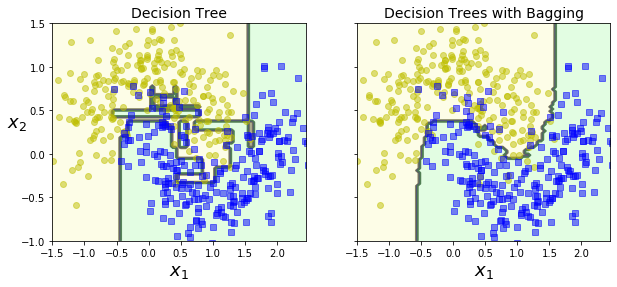

In [11]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

## Out-of-Bag Evaluation
- As each predictor is only trained on a sampled set of training instances, the rest are called the **out-of-bag (oob)** instances.
- By setting `oob_score=True` in BaggingClassifier, we can request an automatic oob evaluation after training.

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, random_state=42,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9253333333333333

## Random Patches and Random Subspaces
- The BaggingClassifier class supports **sampling the features** as well. 
    - This is controlled by two hyperparameters: `max_features` and `bootstrap_features`.
- **Sampling both training instances and features** is called the **Random Patches** method.
- **Keeping all training instances** (i.e., `bootstrap=False` and `max_samples=1.0`) but **sampling features** (i.e., `bootstrap_features=True` and/or `max_features` smaller than 1.0) is called the **Random Subspaces** method.

# Random Forests
- A **Random Forest** is an **ensemble of Decision Trees**, generally trained via the **bagging** method (or sometimes pasting), typically with max_samples set to the size of the training set.
- The Random Forest algorithm introduces **extra randomness** when growing trees: instead of searching for the very best feature when splitting a node (see Chapter 6), it **searches for the best feature** among a **random subset of features**.
- We can use sklearn's **RandomForestClassifier** class to build a Random Forest model.
    - With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.
- The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier.

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42
)

In [14]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.92

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

In [16]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

## Extra-Trees
- In a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). 
- It is possible to **make trees even more random** by also using **random thresholds for each feature** rather than searching for the best possible thresholds.
- A forest of such extremely random trees is simply called an **Extremely Randomized Trees** ensemble (or **Extra-Trees** for short).
- You can create an Extra-Trees classifier using Scikit-Learn’s **ExtraTreesClassifier** class. 
    - Its API is identical to the RandomForestClassifier class. 
- Similarly, the **ExtraTreesRegressor** class has the same API as the RandomForestRegressor class.

## Feature Importance
- Another great quality of Random Forests is that they make it easy to measure the **relative importance of each feature**. 
    - Scikit-Learn measures a feature’s importance by looking at **how much the tree nodes that use that feature reduce impurity on average** (across all trees in the forest).
    - You can access the result using the `feature_importances_` variable.

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


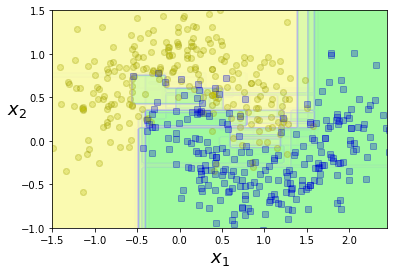

In [18]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

- Another example using MNIST dataset.

In [19]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot,
              interpolation='nearest')
    plt.axis("off")

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

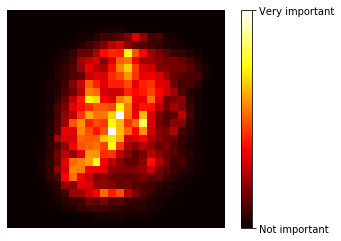

In [22]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# Boosting
- **Boosting** (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. 
- The general idea of most boosting methods is to **train predictors sequentially**, each trying to **correct its predecessor**.

## AdaBoost
- One way for a new predictor to correct its predecessor is to pay a bit **more attention** to the **training instances** that the predecessor **underfitted**.
- Algorithm:
    - Each **instance weight $w(i)$** is initially set to $1/m$. 
    - A first predictor is trained and its **weighted error rate $r_1$** is computed on the training set.
    - The **predictor’s weight $\alpha_j$** is then computed based on $r_j$, where **$\eta$** is the **learning rate hyperparameter** (defaults to 1). 
        - The more accurate the predictor is, the higher its weight will be.
    - Next the instance weights are updated based on $w_i$ and $\alpha_j$: the misclassified instances are boosted.
    - Finally, a new predictor is trained using the updated weights, and the whole process is repeated.
    - To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

- The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s **AdaBoostClassifier** class.
    - As you might expect, there is also an **AdaBoostRegressor** class. 
    - A Decision Stump is a Decision Tree with `max_depth=1`.

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=42
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

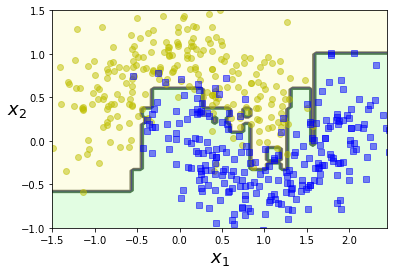

In [24]:
plot_decision_boundary(ada_clf, X, y)

- Compare `learning_rate=0.5` with `learning_rate=1`.

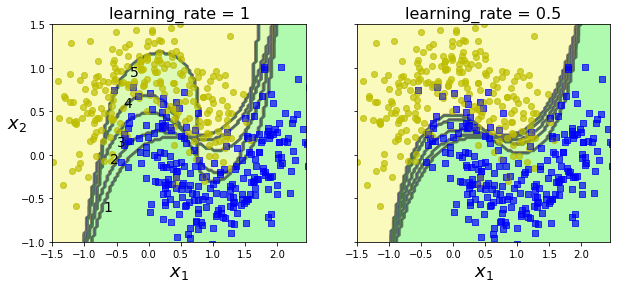

In [25]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

## Gradient Boosting
- Just like AdaBoost, Gradient Boosting works by **sequentially adding predictors** to an ensemble, each one correcting its predecessor. 
- However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to **fit the new predictor** to the **residual errors** made by the previous predictor.
- To do this, we use Scikit-Learn’s **GradientBoostingRegressor** class. 
    - Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth`, `min_samples_leaf`, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`).
    - The **learning_rate** hyperparameter scales the **contribution of each tree**. 
        - If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. 
        - This is a regularization technique called **shrinkage**.

- The following code builds two **Gradient Tree Boosting** or **Gradient Boosted Regression Trees (GBRT)** models with different learning rates and number of underlying Decision Tree predictors.

In [26]:
np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Text(0.5, 0, '$x_1$')

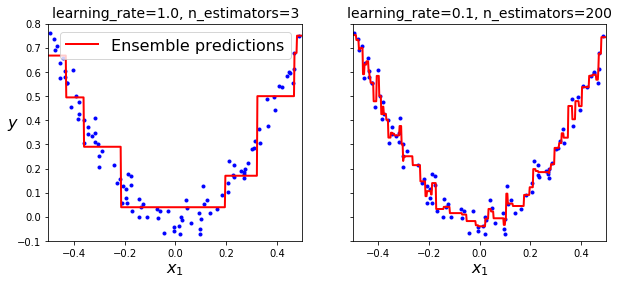

In [29]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

- From the graphs above, we can see that:
    - The GBRT ensemble on the left does not have enough trees to fit the training set (`n_estimators=3`).
    - The one on the right has too many trees and overfits the training set (`n_estimators=200`).

## Gradient Boosting with Early Stopping
- As mentioned above, we need to find the optimal number of predictors in the ensemble model.
- In order to find the optimal number of trees, you can use **early stopping**.
- A simple way to implement this is to use the `staged_predict()` method: 
    - it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). 

- The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees.

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

In [32]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
mean_squared_error(y_val, gbrt.predict(X_val)), mean_squared_error(y_val, gbrt_best.predict(X_val))

(0.0029918838620364174, 0.002712853325235463)

In [34]:
min_error = np.min(errors)

Text(0.5, 0, '$x_1$')

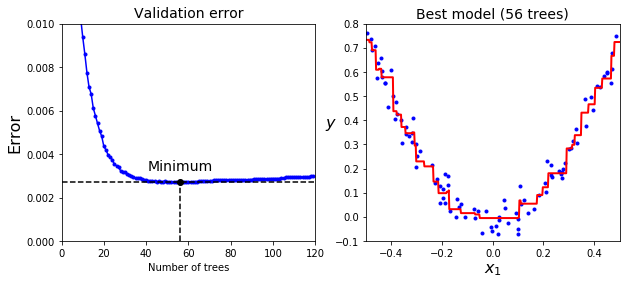

In [35]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

- Besides training a large number of trees and looking back to the optimal value for n_estimators, we can also implement **Early Stopping** directly.
- We need to set `warm_start=True` in GradientBoostingRegressor.

In [36]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [37]:
gbrt.n_estimators

61

In [38]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


- The GradientBoostingRegressor class also supports a **subsample** hyperparameter, which specifies the fraction of training instances used to train each tree regressor.
- As expected, this trades **a higher bias for a lower variance**.
- This technique is called **Stochastic Gradient Boosting**.

## Using XGBoost
- It is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library **XGBoost**, which stands for Extreme Gradient Boosting.

In [39]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [40]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
mean_squared_error(y_val, y_pred)

[10:57:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.0028512559726563943

- XGBoost also offers several nice features, such as **automatically** taking care of **early stopping**.
    - We need to specify **eval_set** and **early_stopping_rounds** in `xgb_reg.fit()`.

In [41]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
mean_squared_error(y_val, y_pred)

[10:58:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[

0.002528626115371327

# Stacking
- The intuition behind Stacking is that, instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, we can **train a model to perform this aggregation**.
- In other words, after training the bottom predictors that predict different values, we can then train a **final predictor** (called a **blender**, or a **meta learner**) takes these predictions as inputs and makes the final prediction.
- Unfortunately, Sklearn does not support stacking directly.

# Exercise
## 8. Voting Classifier
- Load the MNIST data (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). 

In [42]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target

In [43]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

- Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM. 

In [44]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [45]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [46]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print("Training: ", estimator)
    estimator.fit(X_train, y_train)

Training:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training:  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     

/Users/yuangchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [47]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8641, 0.9614]

- Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier. Once you have found one, try it on the test set.

In [48]:
from sklearn.ensemble import VotingClassifier

In [49]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)
]

In [50]:
voting_clf = VotingClassifier(named_estimators,voting='hard')

voting_clf.fit(X_train, y_train)

/Users/yuangchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [51]:
voting_clf.score(X_val, y_val)

0.9704

- Let's try removing SVM from the ensemble and see if the ensemble's performance is improved.

In [52]:
del voting_clf.estimators_[2]

In [53]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs

In [54]:
voting_clf.score(X_val, y_val)

0.9738

- Now, let's try using soft voting instead of hard voting.

In [55]:
voting_clf.voting = "soft"

voting_clf.score(X_val, y_val)

0.9693

- Since hard voting delivered a better validation error, let's change it back.
- Then, let's apply the voting classifier on the test set and compare its performance with individual classifiers.

In [56]:
voting_clf.voting = "hard"

voting_clf.score(X_test, y_test)

0.9705

In [57]:
[estimator.score(X_test, y_test) for estimator in estimators]

[0.9645, 0.9691, 0.8642, 0.9608]

## 9. Stacking Ensemble
- Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions.
    - Each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class.
- Train a classifier (blender) on this new training set.

In [58]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [59]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [60]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
rnd_forest_blender.oob_score_

0.97

- Now, apply this Stacking Ensemble to the test set.

In [62]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [63]:
accuracy_score(y_test, rnd_forest_blender.predict(X_test_predictions))

0.9668